In [4]:
import numpy as np
from os import listdir
from os.path import isfile, join

### Reading data

The sets in the dataset are divided into five categories.


SET A:	Z directory with	Z000.txt - Z100.txt<br>
SET B: 	O directory with	O000.txt - O100.txt<br>
SET C:	N directory with	N000.txt - N100.txt<br>
SET D:	F directory	with	F000.txt - F100.txt<br>
SET E:	S directory with	S000.txt - S100.txt<br>

In [5]:
mapping_set_to_dir = {
    'A': (0,'Z'),
    'B': (1,'O'),
    'C': (2,'N'),
    'D': (3,'F'),
    'E': (4,'S')
}

file_lists = []
for s,d in mapping_set_to_dir.items():
    file_lists.insert(d[0], [f for f in listdir(d[1]) if isfile(join(d[1], f))])

In [4]:
file_lists[4]

['S008.txt',
 'S020.txt',
 'S034.txt',
 'S035.txt',
 'S021.txt',
 'S009.txt',
 'S037.txt',
 'S023.txt',
 'S022.txt',
 'S036.txt',
 'S032.txt',
 'S026.txt',
 'S027.txt',
 'S033.txt',
 'S025.txt',
 'S031.txt',
 'S019.txt',
 'S018.txt',
 'S030.txt',
 'S024.txt',
 'S043.txt',
 'S057.txt',
 'S080.txt',
 'S094.txt',
 'S095.txt',
 'S081.txt',
 'S056.txt',
 'S042.txt',
 'S068.txt',
 'S054.txt',
 'S040.txt',
 'S097.txt',
 'S083.txt',
 'S082.txt',
 'S096.txt',
 'S041.txt',
 'S055.txt',
 'S069.txt',
 'S051.txt',
 'S045.txt',
 'S079.txt',
 'S092.txt',
 'S086.txt',
 'S087.txt',
 'S093.txt',
 'S078.txt',
 'S044.txt',
 'S050.txt',
 'S046.txt',
 'S052.txt',
 'S085.txt',
 'S091.txt',
 'S090.txt',
 'S084.txt',
 'S053.txt',
 'S047.txt',
 'S062.txt',
 'S076.txt',
 'S089.txt',
 'S088.txt',
 'S077.txt',
 'S063.txt',
 'S049.txt',
 'S075.txt',
 'S061.txt',
 'S100.txt',
 'S060.txt',
 'S074.txt',
 'S048.txt',
 'S070.txt',
 'S064.txt',
 'S058.txt',
 'S059.txt',
 'S065.txt',
 'S071.txt',
 'S067.txt',
 'S073.txt',

In [8]:
raw_dataset = { }

for s,d in mapping_set_to_dir.items():
    
    for f in file_lists[d[0]]:
        curr_example = np.loadtxt(join(d[1], f))
        

        if (s in raw_dataset):
            raw_dataset[s] = np.append(raw_dataset[s], [curr_example], axis=0)
        else:
            raw_dataset[s] = np.array([curr_example])

In [9]:
raw_dataset['E'].shape

(100, 4097)

In [10]:
import matplotlib.pyplot as plt

## Visualizing data

Each training example in raw_dataset contains an EEG signal of 4097 data points.<br>
The values represent the values of voltage levels observed by the electrodes.<br>

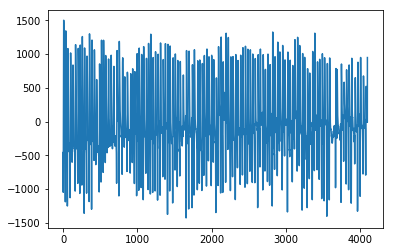

In [11]:
s = 'E'
index = 40
plt.plot(raw_dataset[s][index])

## Data augmentation

Since neural networks are hungry for data to perform adequately, and the available data has only 500 examples of data (100 per set). A good solution to this problem would be to split the data into smaller signals. In this manner, we'll have lots of examples, albeit small.

The below procedure uses sliding window with specified `window_size` and `stride` and returns a new dataset.

In [12]:
def create_augmented_dataset(raw_dataset, window_size = 512, stride = 64, verbose=False):
    augmented_dataset = { }

    for s,Xset_raw in raw_dataset.items():
        
        if (verbose):
            print('Processing set ' + s)

        total_points = Xset_raw.shape[1]

        # no. of examples generated from single training example using sliding window
        # = floor((total_points - window_size) / stride) + 1
        iterations = ((total_points - window_size) // stride) + 1

        for x_raw in Xset_raw:

            for i in range(iterations):
                window_slice_from = i*stride
                window_slice_to = i*stride + window_size

                if (s in augmented_dataset):
                    augmented_dataset[s] = np.append(augmented_dataset[s], [x_raw[window_slice_from:window_slice_to]], axis=0)
                else:
                    augmented_dataset[s] = np.array([x_raw[window_slice_from:window_slice_to]])

    
    if (verbose):
        print('Done.')
    return augmented_dataset


# Splitting of the data

Our methodology to split the data is ...

In [13]:
raw_dataset_train = { }
raw_dataset_dev = { }
raw_dataset_test = { }

for s,Xset_raw in raw_dataset.items():
    
    # randomly shuffle the data, just to make sure
    # that all train/dev/test sets come from same
    # distribution, (possibly not from a same person)
    np.random.shuffle(raw_dataset[s])
    
    ninety_percent = np.floor(0.9 * raw_dataset[s].shape[0]).astype(int)
    five_percent = np.floor(0.05 * raw_dataset[s].shape[0]).astype(int)
    
    # train set 0 - 89 (90%)
    raw_dataset_train[s] = raw_dataset[s][0:ninety_percent,:]
    
    # dev set 90 - 94 (5%)
    raw_dataset_dev[s] = raw_dataset[s][ninety_percent:ninety_percent+five_percent,:]
    
    # test set 95 - 99 (5%)
    raw_dataset_test[s] = raw_dataset[s][ninety_percent+five_percent:,:]

In [14]:
print(raw_dataset_train['D'].shape)
print(raw_dataset_dev['A'].shape)
print(raw_dataset_test['C'].shape)

(90, 4097)
(5, 4097)
(5, 4097)


#### Scheme - 1

Let's try splitting the data with the window size of 512 and stride of 64. As done in the Scheme-1 of the Paper by Ihsan Ullah et. al. This method creates 28,500 examples from 500 examples. (5700 per set).

In [15]:
print("Augmenting training data")
aug_dataset512_train = create_augmented_dataset(raw_dataset_train, window_size=512, stride=64, verbose=True)

print("Augmenting dev data")
aug_dataset512_dev = create_augmented_dataset(raw_dataset_dev, window_size=512, stride=256, verbose=True)

print("Augmenting test data")
aug_dataset512_test = create_augmented_dataset(raw_dataset_test, window_size=512, stride=256, verbose=True)

Augmenting training data
Processing set A


KeyboardInterrupt: 

#### Scheme - 2

Also, try the window size of 1024 with the stride of 128. Creates 12,500 examples (2500 per set).

In [ ]:
print('Augmenting training data')
aug_dataset1024_train = create_augmented_dataset(raw_dataset_train, window_size=1024, stride=128, verbose=True)

print ('Augmenting dev data')
aug_dataset1024_dev = create_augmented_dataset(raw_dataset_dev, window_size=1024, stride=512, verbose=True)

print('Augmenting test data')
aug_dataset1024_test = create_augmented_dataset(raw_dataset_test, window_size=1024, stride=512, verbose=True)

In [ ]:
print(aug_dataset512_train['E'].shape)
print(aug_dataset512_dev['C'].shape)
print(aug_dataset512_test['D'].shape)

In [ ]:
print(aug_dataset1024_train['E'].shape)
print(aug_dataset1024_dev['C'].shape)
print(aug_dataset1024_test['D'].shape)

## Saving the data

Calling the `create_augmented_dataset` for the above parameters takes few minutes each time. To speed up learning these augmented datasets are saved to the disk so that they can be loaded next time feasibly. We use a popular library called `h5py` for this purpose.

In [18]:
import h5py as h5

In [36]:
with h5.File('aug_dataset512.h5', 'w') as aug_file512:
    
    train512 = aug_file512.create_group('train')
    dev512 = aug_file512.create_group('dev')
    test512 = aug_file512.create_group('test')

    for s in aug_dataset512_train.keys():
        
        train512.create_dataset(s, data=aug_dataset512_train[s])
        dev512.create_dataset(s, data=aug_dataset512_dev[s])
        test512.create_dataset(s, data=aug_dataset512_test[s])
        

In [17]:
with h5.File('aug_dataset1024.h5', 'w') as aug_file1024:
    
    train1024 = aug_file1024.create_group('train')
    dev1024 = aug_file1024.create_group('dev')
    test1024 = aug_file1024.create_group('test')

    for s in aug_dataset1024_train.keys():
        
        train1024.create_dataset(s, data=aug_dataset1024_train[s])
        dev1024.create_dataset(s, data=aug_dataset1024_dev[s])
        test1024.create_dataset(s, data=aug_dataset1024_test[s])

NameError: name 'h5' is not defined

In [16]:
aug_file512 = h5.File('aug_dataset512.h5', 'r')
print(aug_file512['train']['A'].shape)
print(aug_file512['dev']['C'].shape)
print(aug_file512['test']['D'].shape)

NameError: name 'h5' is not defined

In [20]:
aug_file1024 = h5.File('aug_dataset1024.h5', 'r')
print(aug_file1024['train']['A'].shape)
print(aug_file1024['dev']['C'].shape)
print(aug_file1024['test']['D'].shape)

(2250, 1024)
(35, 1024)
(35, 1024)


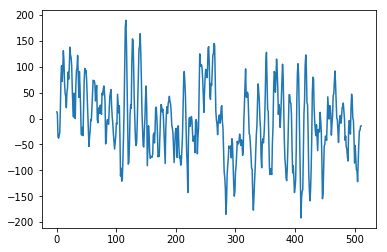

In [31]:
s = 'B'
index = 400
plt.plot(aug_file512['train'][s][index])

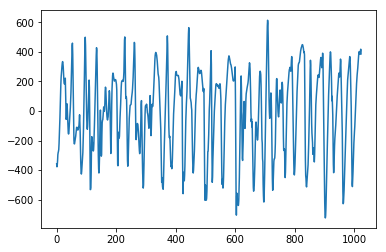

In [36]:
s = 'E'
index = 175
plt.plot(aug_file1024['train'][s][index])

In [40]:
aug_file512.close()

In [41]:
aug_file1024.close()